In [1]:
from datetime import datetime 
import pandas as pd
from utils import simulator_period,save_sim_resuls
from subjects.corr_coef import CorrCoeff,TrendFunc
import numpy as np
import matplotlib.pyplot as plt

In [2]:
casino_fig=pd.read_csv('casino_fig.csv', parse_dates = ['Date'])

In [3]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands
0,2022-01-01,34,2924.200831,57765.485289,4033
1,2022-01-02,19,507.688859,66719.293514,2062
2,2022-01-03,20,1737.412798,33983.499611,2166
3,2022-01-04,12,131.994872,45132.474347,1214
4,2022-01-05,8,-381.229482,49338.352483,1528


In [4]:
casino_fig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1097 entries, 0 to 1096
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   Date         1097 non-null   datetime64[ns]
 1   Heads        1097 non-null   int64         
 2   Day_Result   1097 non-null   float64       
 3   Total_Bets   1097 non-null   float64       
 4   Total_Hands  1097 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 43.0 KB


<Axes: xlabel='Date'>

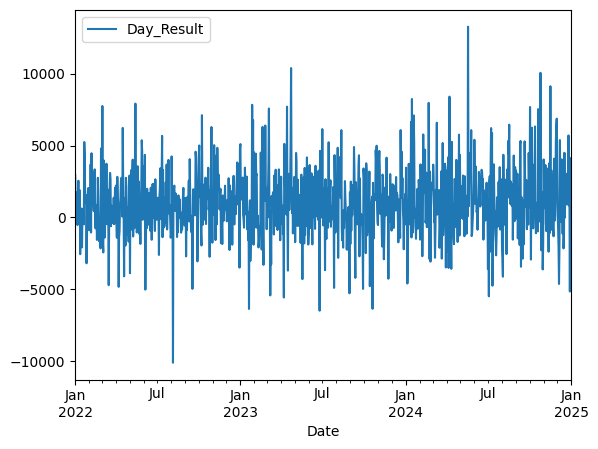

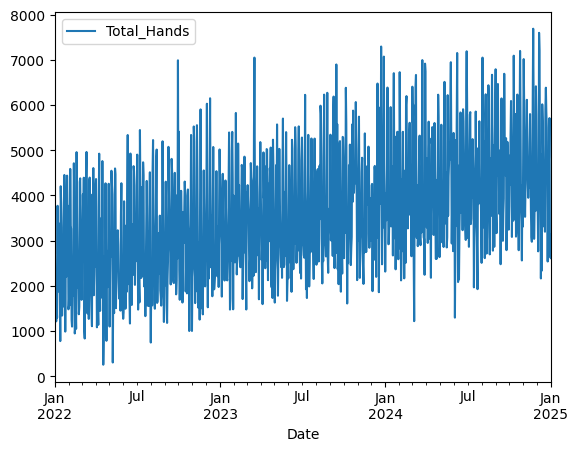

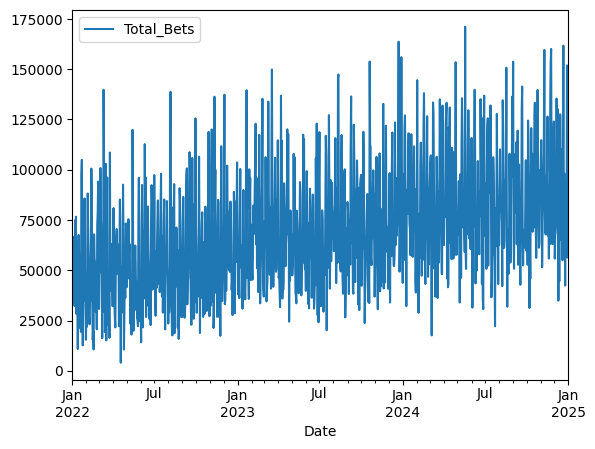

In [5]:
casino_fig[:].plot(x="Date", y ="Day_Result")
casino_fig[:].plot(x="Date", y ="Total_Hands")
casino_fig[:].plot(x="Date", y ="Total_Bets")


In [6]:
casino_fig['Day_Result_roll'] = casino_fig['Day_Result'].rolling(window=7).mean()

<Axes: xlabel='Date'>

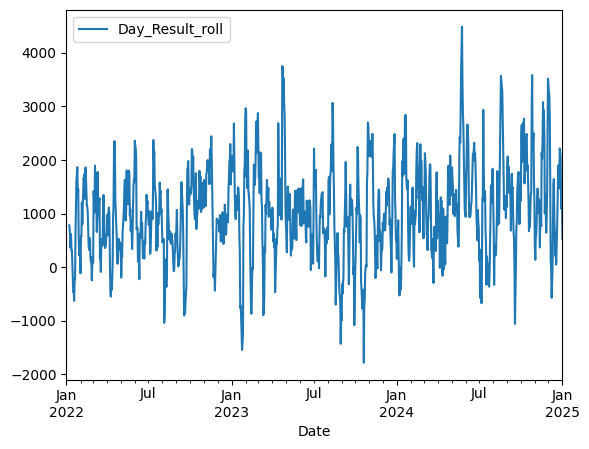

In [7]:
casino_fig.plot(x="Date", y ="Day_Result_roll")

In [8]:
from scipy.signal import medfilt

In [9]:
casino_fig['Day_Result_med'] = medfilt(casino_fig['Day_Result'], kernel_size=49)

<Axes: xlabel='Date'>

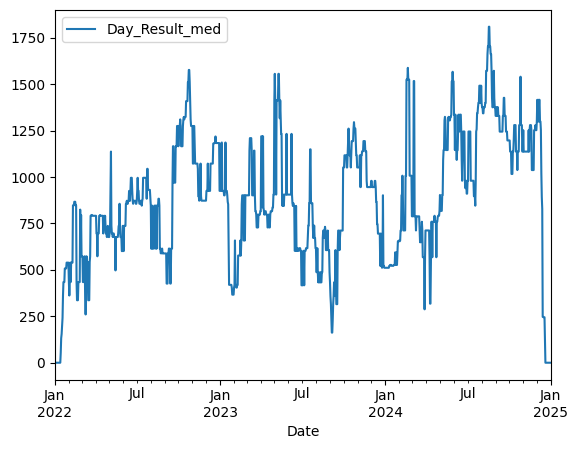

In [10]:
casino_fig.plot(x="Date", y ="Day_Result_med")

In [11]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=7, adjust=True).mean()


<Axes: xlabel='Date'>

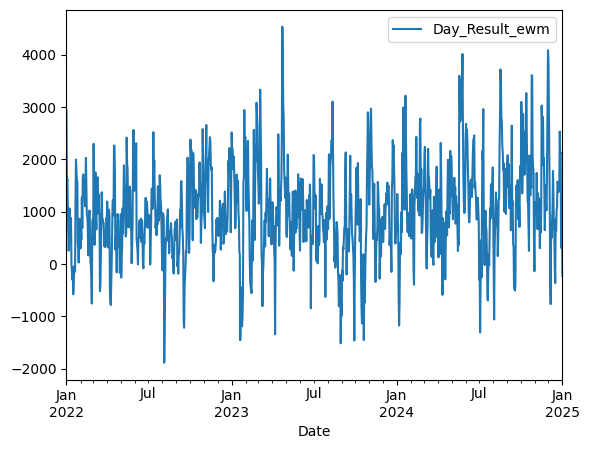

In [12]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [13]:
casino_fig.head()

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm
0,2022-01-01,34,2924.200831,57765.485289,4033,NaN,0.0,2924.200831
1,2022-01-02,19,507.688859,66719.293514,2062,NaN,0.0,1543.336847
2,2022-01-03,20,1737.412798,33983.499611,2166,NaN,0.0,1627.261583
3,2022-01-04,12,131.994872,45132.474347,1214,NaN,0.0,1080.421186
4,2022-01-05,8,-381.229482,49338.352483,1528,NaN,0.0,601.314180


In [14]:
casino_fig['Day_Result_ewm_4'] = casino_fig['Day_Result_ewm'].ewm(span=4, adjust=True).mean()

<Axes: xlabel='Date'>

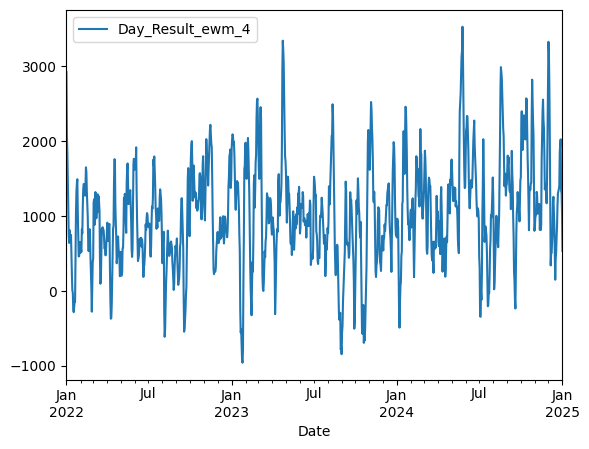

In [15]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4")

In [16]:
casino_fig['Day_Result_ewm_4_12'] = casino_fig['Day_Result_ewm_4'].ewm(span=72, adjust=True).mean()

<Axes: xlabel='Date'>

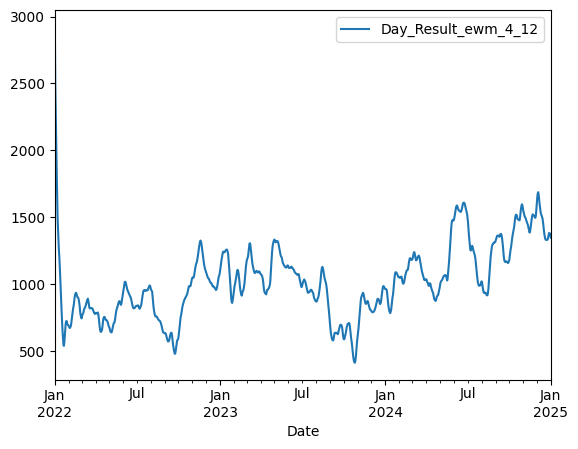

In [17]:
casino_fig.plot(x="Date", y ="Day_Result_ewm_4_12")

In [18]:
casino_fig['Day_Result_ewm'] = casino_fig['Day_Result'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

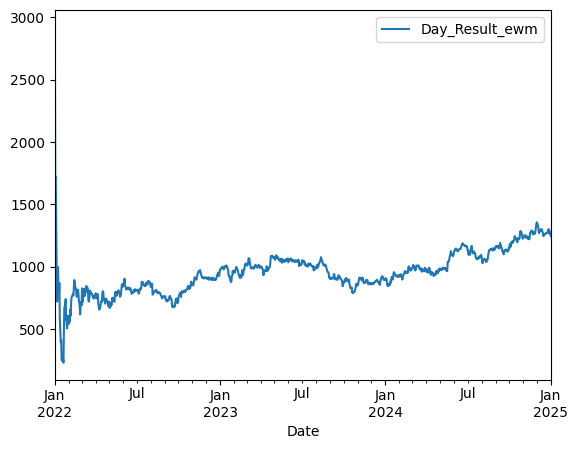

In [19]:
casino_fig.plot(x="Date", y ="Day_Result_ewm")

In [20]:
casino_fig['Total_Bets_ewm'] = casino_fig['Total_Bets'].ewm(span=365, adjust=True).mean()

<Axes: xlabel='Date'>

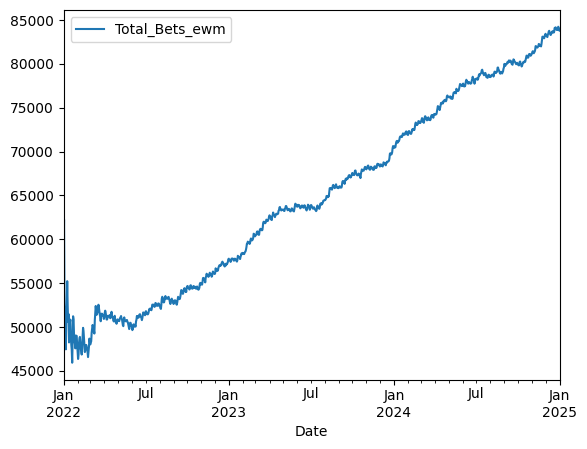

In [21]:
casino_fig.plot(x="Date", y ="Total_Bets_ewm")

In [22]:
from scipy import stats

In [23]:
slope, intercept, r, p, std_err = stats.linregress(casino_fig.index,casino_fig['Total_Bets'])

In [24]:
intercept


np.float64(48430.78640278139)

In [47]:
slope

np.float64(39.11675796408916)

In [25]:
casino_fig['trend_bet']= slope*casino_fig.index+intercept

<Axes: xlabel='Date'>

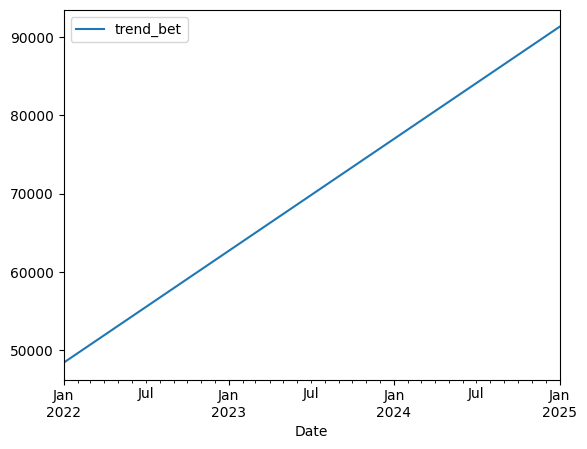

In [26]:
casino_fig.plot(x="Date", y ="trend_bet")

In [27]:
casino_fig['trend_free'] = casino_fig['Total_Bets']-casino_fig['trend_bet'] + intercept

<Axes: xlabel='Date'>

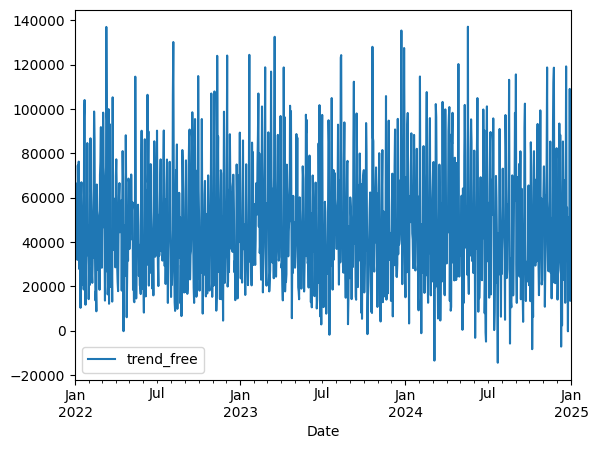

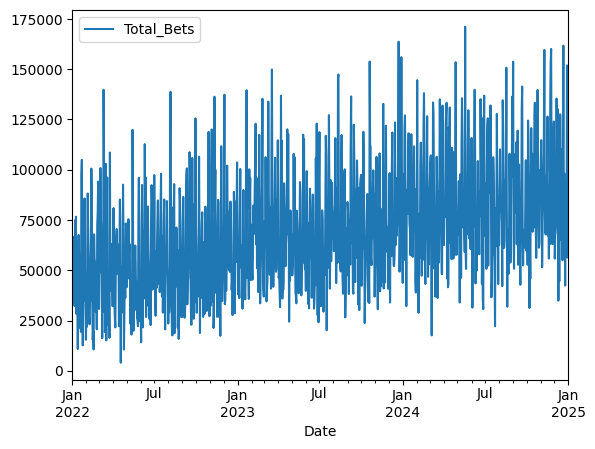

In [28]:
casino_fig.plot(x="Date", y ="trend_free")
casino_fig.plot(x="Date", y ="Total_Bets")

In [29]:
# Perform cubic fit
coefficients = np.polyfit(casino_fig.index,casino_fig['Total_Bets'], 1)
print(coefficients)

[3.91167580e+01 4.84307864e+04]


In [30]:
p = np.poly1d(coefficients)

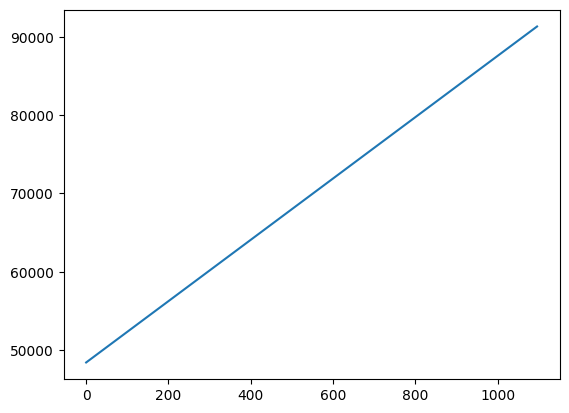

In [31]:
plt.plot(casino_fig.index,p(casino_fig.index))

In [32]:
casino_fig['Date'].iloc[0].weekday() 

5

In [33]:
casino_fig['week_day'] = casino_fig['Date'].dt.dayofweek

In [34]:
casino_fig['week_day']

0       5
1       6
2       0
3       1
4       2
       ..
1092    5
1093    6
1094    0
1095    1
1096    2
Name: week_day, Length: 1097, dtype: int32

In [35]:
casino_fig.groupby('week_day')['trend_free'].mean()

week_day
0    25323.712761
1    33468.988097
2    37301.947796
3    32057.803668
4    72899.319179
5    78953.025464
6    59062.271868
Name: trend_free, dtype: float64

In [36]:
bet_df =casino_fig.groupby('week_day')['trend_free'].agg([ 'mean','std'])

In [37]:
bet_df['low_res'] = bet_df['mean'] - 2* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 2* bet_df['std']

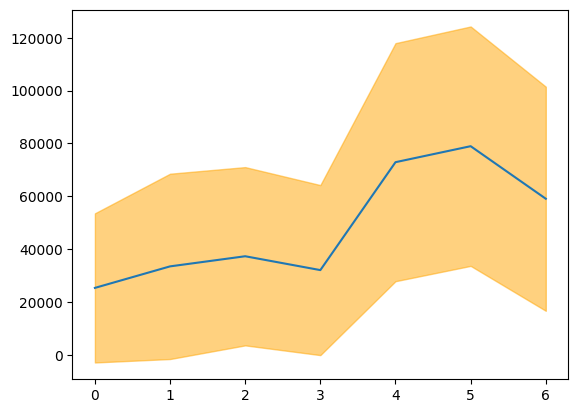

In [38]:
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

In [39]:
bet_df.index

Index([0, 1, 2, 3, 4, 5, 6], dtype='int32', name='week_day')

In [40]:
casino_fig.tail(10)

,Date,Heads,Day_Result,Total_Bets,Total_Hands,Day_Result_roll,Day_Result_med,Day_Result_ewm,Day_Result_ewm_4,Day_Result_ewm_4_12,Total_Bets_ewm,trend_bet,trend_free,week_day
1087,2024-12-23,25,892.073564,98129.430545,5502,1898.554806,0.0,1270.029172,1331.590531,1330.654727,84159.346507,90950.702310,55609.514638,0
1088,2024-12-24,29,1510.491822,74844.477621,4267,1472.021559,0.0,1271.346550,1362.281543,1331.521215,84108.314864,90989.819068,32285.444956,1
1089,2024-12-25,22,1667.742459,42384.604976,2538,1712.300926,0.0,1273.518181,1406.638590,1333.579225,83879.734125,91028.935826,-213.544447,2
1090,2024-12-26,20,5702.481392,85872.129086,3883,2217.254086,0.0,1297.781640,1856.183541,1347.897151,83890.649184,91068.052584,43234.862905,3
1091,2024-12-27,45,827.781275,93903.910135,4600,2149.909029,0.0,1295.206844,1955.638543,1364.547600,83945.504682,91107.169342,51227.527196,4
1092,2024-12-28,39,2208.322995,67627.294758,4850,2032.099199,0.0,1300.209086,2025.661739,1382.660317,83856.110110,91146.286100,24911.795061,5
1093,2024-12-29,38,-5159.978984,151864.821099,5711,1092.702075,0.0,1264.819308,1338.608105,1381.453407,84228.670957,91185.402858,109110.204644,6
1094,2024-12-30,21,4129.647632,56306.371155,2641,1555.212656,0.0,1280.513008,1308.537922,1379.455722,84075.710940,91224.519615,13512.637942,0
1095,2024-12-31,28,-1207.287232,57586.864582,3137,1166.958505,0.0,1266.884876,1043.423824,1370.249369,83930.605436,91263.636373,14754.014611,1
1096,2025-01-01,31,-2845.793524,57261.247642,2612,522.167651,0.0,1244.355989,535.200746,1347.371324,83784.513065,91302.753131,14389.280913,2


In [41]:
casino_fig['Total_Bets'][1087:1094]

1087     98129.430545
1088     74844.477621
1089     42384.604976
1090     85872.129086
1091     93903.910135
1092     67627.294758
1093    151864.821099
Name: Total_Bets, dtype: float64

In [42]:
casino_fig['week_day'][1087:1094]

1087    0
1088    1
1089    2
1090    3
1091    4
1092    5
1093    6
Name: week_day, dtype: int32

In [43]:
bet_df['mean']  = casino_fig.index[1087:1094]*slope + bet_df['mean']

In [44]:
bet_df['low_res'] = bet_df['mean'] - 3* bet_df['std']
bet_df['high_res'] = bet_df['mean'] + 3* bet_df['std']

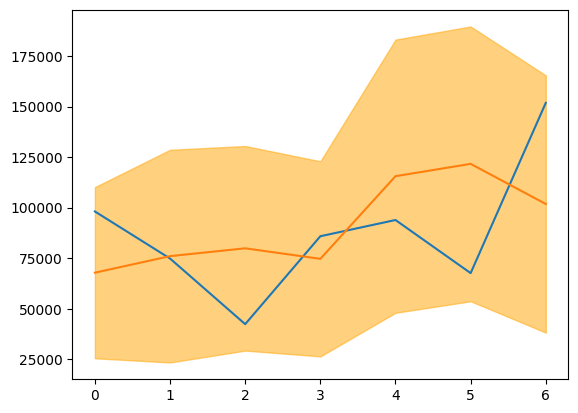

In [45]:
plt.plot(bet_df.index ,casino_fig['Total_Bets'][1087:1094] )
plt.plot(bet_df.index ,bet_df['mean'] )
plt.fill_between(bet_df.index, bet_df['low_res'], bet_df['high_res'], alpha=0.5, color='orange')

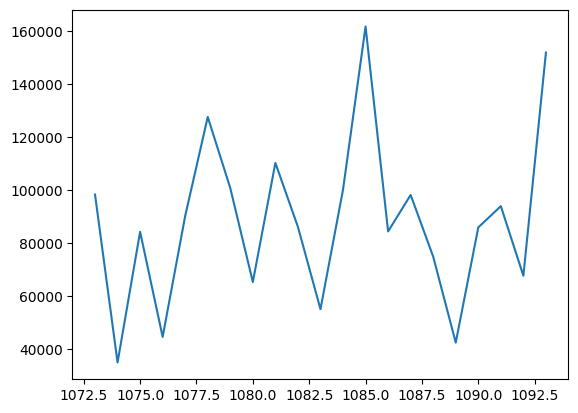

In [46]:
plt.plot(casino_fig['Total_Bets'][1073:1094] )